#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the IMD dataset that can be easily downloaded using Keras. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


Let's also get the word indexs (word to word-id)

*   List item
*   List item



In [3]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

Since the model performs a binary classification task, we use cross-entropy as loss.

In [9]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [11]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 26s 134ms/step - loss: 0.6462 - accuracy: 0.6042 - val_loss: 0.4323 - val_accuracy: 0.8059
Epoch 2/10
196/196 [==============================] - 26s 131ms/step - loss: 0.4354 - accuracy: 0.7908 - val_loss: 0.5854 - val_accuracy: 0.6939
Epoch 3/10
196/196 [==============================] - 26s 130ms/step - loss: 0.4350 - accuracy: 0.8016 - val_loss: 0.3735 - val_accuracy: 0.8430
Epoch 4/10
196/196 [==============================] - 26s 131ms/step - loss: 0.2703 - accuracy: 0.8945 - val_loss: 0.3668 - val_accuracy: 0.8490
Epoch 5/10
196/196 [==============================] - 26s 131ms/step - loss: 0.2196 - accuracy: 0.9192 - val_loss: 0.3832 - val_accuracy: 0.8482
Epoch 6/10
196/196 [==============================] - 26s 131ms/step - loss: 0.1893 - accuracy: 0.9320 - val_loss: 0.4034 - val_accuracy: 0.8440
Epoch 7/10
196/196 [==============================] - 26s 131ms/step - loss: 0.1816 - accuracy: 0.9350 - val_loss: 0.4213 - val_ac

In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 8s - loss: 0.4370 - accuracy: 0.8427
accuracy: 84.27%


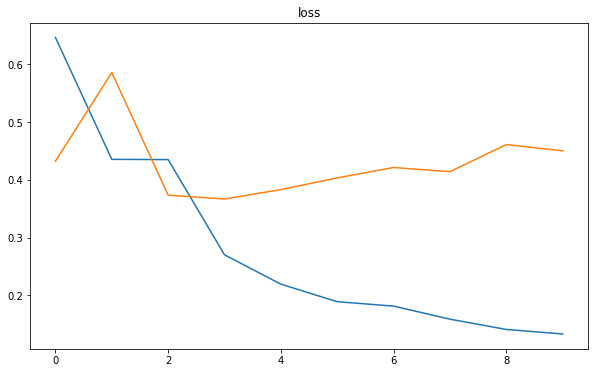

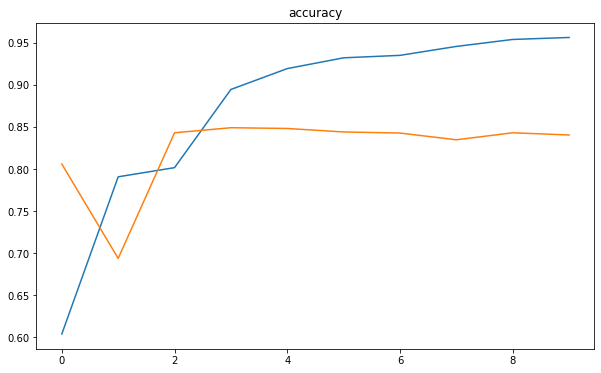

In [13]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##Exercise 4.1: LSTM and GRU
**To complete**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**To complete**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?


In [ ]:
model_LSTM = keras.models.Sequential()
model_LSTM.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_LSTM.add(keras.layers.LSTM(14))
model_LSTM.add(keras.layers.Dense(1, activation="sigmoid"))
model_LSTM.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_LSTM.summary()
history_LSTM = model_LSTM.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 14)                1400      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 57s 292ms/step - loss: 0.5471 - accuracy: 0.7218 - val_loss: 0.3772 - val_accuracy: 0.8442
Epoch 2/10
196/196 [==============================] - 60s 305ms/step - loss: 0.2919 - accuracy: 0.8835 - val_loss: 0.3195 - val_accuracy: 0.8700
Epoch 3/10
196/196 [==============================] - 61s 310ms/step - loss: 0.2133 - a

391/391 - 14s - loss: 0.4874 - accuracy: 0.8578
accuracy: 85.78%


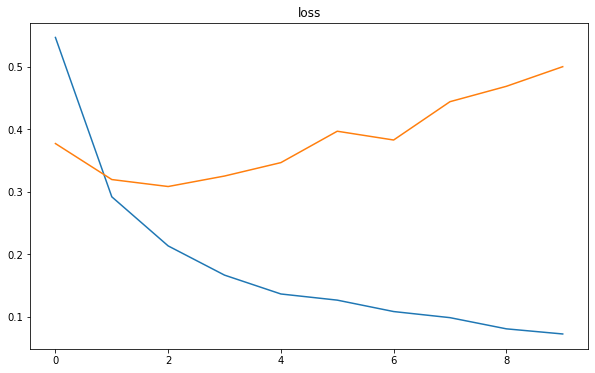

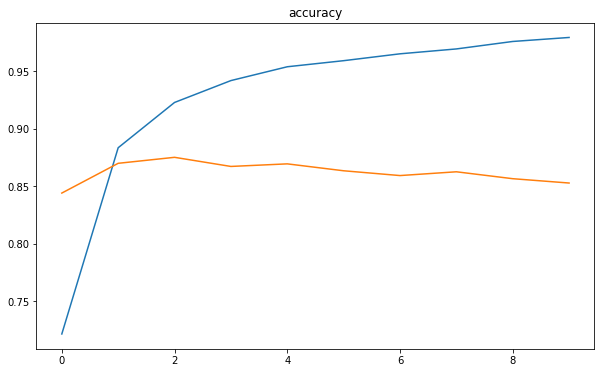

In [ ]:
plot_loss(history_LSTM)

plot_accuracy(history_LSTM)

scores_LSTM = model_LSTM.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], scores_LSTM[1]*100))

In [ ]:
model_GRU = keras.models.Sequential()
model_GRU.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_GRU.add(keras.layers.GRU(16))
model_GRU.add(keras.layers.Dense(1, activation="sigmoid"))
model_GRU.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_GRU.summary()
history_GRU = model_GRU.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
gru_7 (GRU)                  (None, 16)                1344      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 58s 296ms/step - loss: 0.5571 - accuracy: 0.6977 - val_loss: 0.3764 - val_accuracy: 0.8362
Epoch 2/10
196/196 [==============================] - 57s 292ms/step - loss: 0.3036 - accuracy: 0.8727 - val_loss: 0.3641 - val_accuracy: 0.8439
Epoch 3/10
196/196 [==============================] - 57s 292ms/step - loss: 0.2251 - a

391/391 - 12s - loss: 0.5189 - accuracy: 0.8482
accuracy: 84.82%


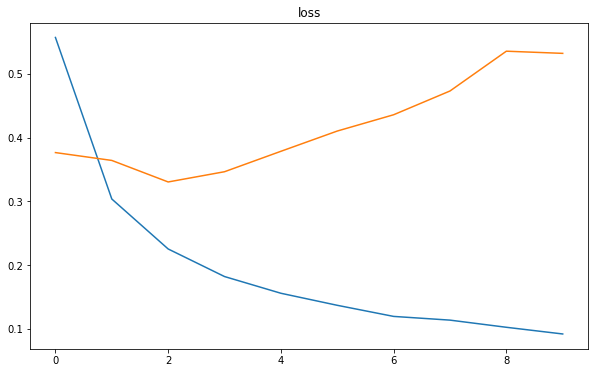

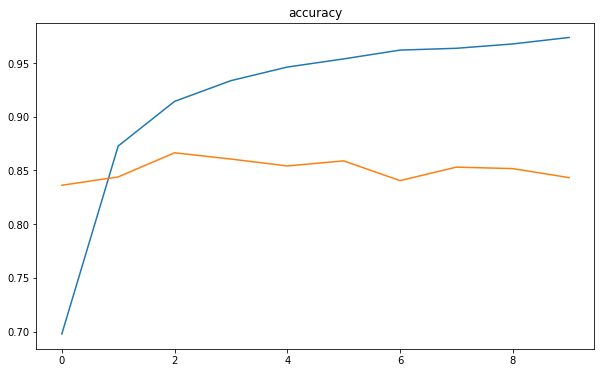

In [ ]:
plot_loss(history_GRU)

plot_accuracy(history_GRU)

scores_GRU = model_GRU.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_GRU.metrics_names[1], scores_GRU[1]*100))

How we can see, both LSTM and GRU requires about half of the units of RNN(LSTM less). 

In terms of performance, both them performs better than simple RNN but not so much better with a best of 85% from LSTM.

In end, both LSTM and GRU requires about the same time to train, which is the double of simple RNN's.  


##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [14]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 82s 524ms/step - loss: 0.6530 - accuracy: 0.6360 - val_loss: 0.5151 - val_accuracy: 0.7674
Epoch 2/10
157/157 [==============================] - 82s 523ms/step - loss: 0.4069 - accuracy: 0.8389 - val_loss: 0.3813 - val_accuracy: 0.8456
Epoch 3/10
157/157 [==============================] - 82s 523ms/step - loss: 0.2789 - ac

391/391 - 20s - loss: 0.4686 - accuracy: 0.8563
accuracy: 85.63%


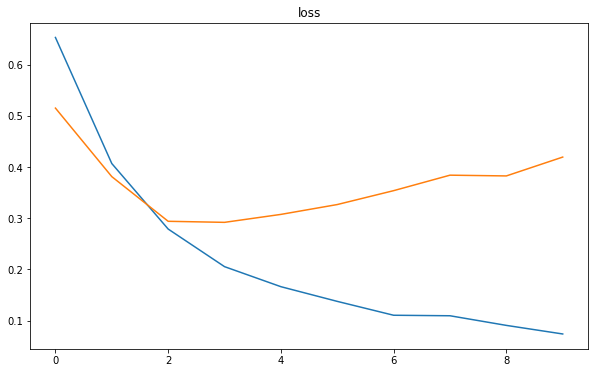

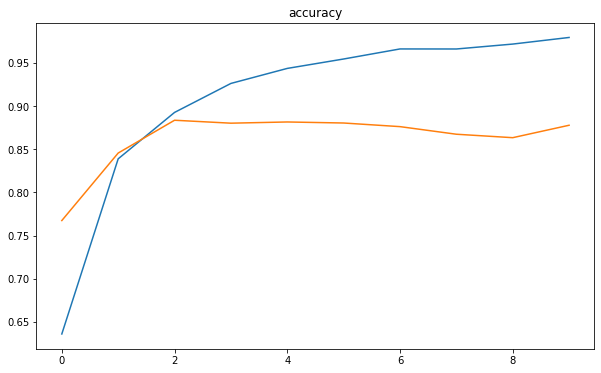

In [15]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##Exercise 4.2: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**To complete**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue. Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion below*

In [ ]:
model_bidirectional_2 = keras.models.Sequential()
model_bidirectional_2.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional_2.add(keras.layers.Dropout(0.05))
model_bidirectional_2.add(keras.layers.Bidirectional(keras.layers.LSTM(10)))
model_bidirectional_2.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional_2.summary()

history_bidirectional_2 = model_bidirectional_2.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 20)                1680      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 101,701
Trainable params: 101,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
157/157 [==============================] - 59s 378ms/step - loss: 0.6365 - accuracy: 0.6261 - val_loss: 0.4701 - val_accuracy: 0.8114
Epoch 2/5
157/157 [==============================] - 59s 377ms/step - loss: 0.4021 - accuracy: 0.8368 

dropout basso
layer lstm nn influisce molto
provare embedding
provare droput anche alla fine
provare loss

This is a good combination i found:

 * By inserting dropout in the output layer, i obtained worse results.
 * A small probability for droput layer after embedding seems to work better than a high probability. This is probably due to the fact that the model couldn't learn good parameters for the memory if data missing are too many.
 * Reducing the number of LSTM units didn't change much the resuts, but this probably lead to less overfit of the model since it is simpler.
 * The greater dimensions of the embedding layer didn't improve the results.
 * Reducing the number of epochs leads to a decrease of the model's overfit.  

391/391 - 16s - loss: 0.3262 - accuracy: 0.8692
accuracy: 86.92%


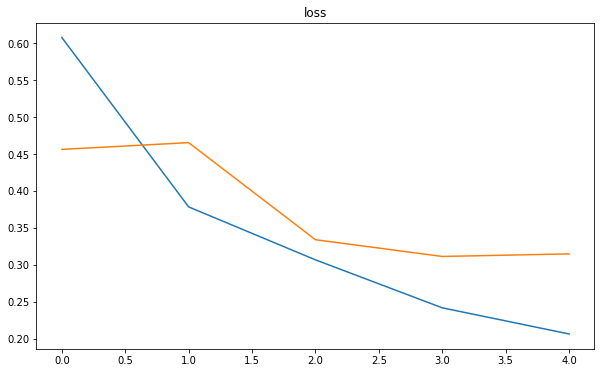

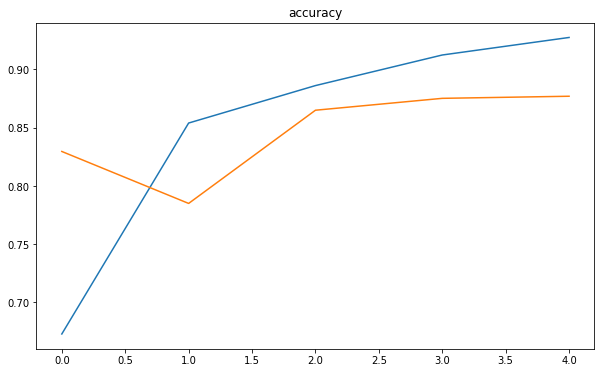

In [ ]:
plot_loss(history_bidirectional_2)

plot_accuracy(history_bidirectional_2)

scores_bidirectional_2 = model_bidirectional_2.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional_2.metrics_names[1], scores_bidirectional_2[1]*100))